In [1]:
%matplotlib inline

import warnings
import datetime
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, validation_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

from matplotlib import pyplot as plt

PATH_TO_DATA = 'data/' 

In [2]:
def create_submition(model, X_train, y_train, X_test, test_index):
    print('Train shape: (%d x %d)' % X_train.shape)
    print('Test shape: (%d x %d)' % X_test.shape)
    
    model.fit(X_train, y_train)
    
    result_df = pd.DataFrame(index=test_index)
    result_df['Survived'] = model.predict(X_test)
    
    name = 'result_' + datetime.datetime.today().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'
    result_df.to_csv(name, index_label='PassengerId')

In [3]:
def validate(model, X_train, y_train):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(cross_val_score(model, X_train, y_train, cv=3))

In [4]:
train_df = pd.read_csv(PATH_TO_DATA+'train_features.csv', index_col='PassengerId')
y_df = pd.read_csv(PATH_TO_DATA+'train.csv', index_col='PassengerId', usecols=['PassengerId', 'Survived'])

In [5]:
num_cols = {'Fare', 'Age', 'Relatives count'}
cat_cols = {'Pclass', 'Sex', 'Embarked', 'Titul', 'Surname', 'Is alone', 'Child survived', 'Husband survived',
            'Wife died', 'Mather died', 'Is child', 'Cabin number', 'Deck', 'Is cabin present', 'Ticket number'}

def create_f_transformer(names):
    ids = np.array([(c in names) for c in train_df.columns], dtype=bool)
    return FunctionTransformer(lambda x: x[:, ids], validate=False)

num_features = make_pipeline(create_f_transformer(num_cols), StandardScaler(with_mean=0))
cat_features = make_pipeline(create_f_transformer(cat_cols), OneHotEncoder(handle_unknown='ignore'))

features_pipe = make_pipeline(FeatureUnion([('numbers', num_features), ('categories', cat_features)]))

In [6]:
X = features_pipe.fit_transform(train_df.values)
y = y_df['Survived'].values

C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
%%time
validate(LogisticRegression(), X, y)

[0.82154882 0.82491582 0.86531987]
Wall time: 32 ms


In [8]:
%%time
validate(RandomForestClassifier(n_estimators=150), X, y)

[0.81481481 0.86195286 0.84848485]
Wall time: 2.1 s


# Baseline submission

In [9]:
test_df = pd.read_csv(PATH_TO_DATA+'test_features.csv', index_col='PassengerId')
test_df.head()

,Pclass,Sex,Embarked,Fare,Titul,Surname,Child survived,Husband survived,Wife died,Mather died,Age,Is child,Relatives count,Cabin number,Deck,Is cabin present,Ticket number,Is alone
PassengerId,,,,,,,,,,,,,,,,,,
892,3,1,Q,2.057860,Mr,Kelly,Unknown,0,0,0,34.5,0,0,0,U,0,330911,0
893,3,0,S,1.945910,Mrs,Wilkes,Unknown,0,0,0,47.0,0,1,0,U,0,363272,0
894,2,1,Q,2.270836,Mr,Myles,Unknown,0,0,0,62.0,0,0,0,U,0,240276,1
895,3,1,S,2.159003,Mr,Wirz,Unknown,0,0,0,27.0,0,0,0,U,0,315154,1
896,3,0,S,2.508582,Mrs,Hirvonen,Survived,0,0,0,22.0,0,2,0,U,0,3101298,0


In [10]:
test_df.count()

Pclass              418
Sex                 418
Embarked            418
Fare                418
Titul               418
Surname             418
Child survived      418
Husband survived    418
Wife died           418
Mather died         418
Age                 418
Is child            418
Relatives count     418
Cabin number        418
Deck                418
Is cabin present    418
Ticket number       418
Is alone            418
dtype: int64

In [11]:
X_test = features_pipe.transform(test_df.values)
create_submition(LogisticRegression(), X, y, X_test, test_df.index.values)

Train shape: (891 x 1485)
Test shape: (418 x 1485)


C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\kipil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score: 0.78947

# RandomForestClassifier

## Random search

In [12]:
%%time
param_dist = {"max_depth": [3, 5, 10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]
             }

model = RandomForestClassifier(n_estimators=100)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=3, return_train_score=True)

random_search.fit(X, y)

Wall time: 20.4 s


In [13]:
print('Best score: %f' % random_search.best_score_)
print('Params:')
for k in random_search.best_params_: print('%s: %s' % (k, random_search.best_params_[k]))

Best score: 0.842873
Params:
bootstrap: False
criterion: entropy
max_depth: None
max_features: 5
min_samples_split: 9


In [14]:
random_columns_to_display = [ 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 
                      'std_test_score', 'param_bootstrap', 'param_criterion', 'param_max_depth', 
                      'param_max_features', 'param_min_samples_split']

In [15]:
cv_result_df = pd.DataFrame(random_search.cv_results_)
cv_result_df.sort_values(by='mean_test_score', ascending=False)[random_columns_to_display].head()

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_split
0,0.811448,0.872054,0.845118,0.842873,0.024793,False,entropy,None,5,9
9,0.808081,0.868687,0.845118,0.840629,0.024945,True,gini,None,5,2
8,0.808081,0.861953,0.848485,0.839506,0.022891,False,entropy,None,5,5
1,0.814815,0.855219,0.848485,0.839506,0.017675,True,entropy,None,9,10
7,0.804714,0.855219,0.845118,0.835017,0.021821,False,gini,None,10,2


## Grid Search

In [16]:
%%time
param_grid = {"max_features": range(1, 10),
              "min_samples_split": range(2, 9),
              "bootstrap": [True, False]}

model = RandomForestClassifier(n_estimators=100)
grid = GridSearchCV(model, param_grid=param_grid, cv=3, return_train_score=False)

grid.fit(X, y)

Wall time: 4min 53s


In [17]:
print('Best score: %f' % grid.best_score_)
print('Params:')
for k in grid.best_params_: print('%s: %s' % (k, grid.best_params_[k]))

Best score: 0.848485
Params:
bootstrap: True
max_features: 3
min_samples_split: 3


In [18]:
grid_columns_to_display = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 
                      'std_test_score', 'param_bootstrap', 'param_max_features', 'param_min_samples_split']

In [19]:
cv_result_df = pd.DataFrame(grid.cv_results_)
cv_result_df.sort_values(by='mean_test_score', ascending=False)[grid_columns_to_display].head()

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,param_bootstrap,param_max_features,param_min_samples_split
15,0.821549,0.872054,0.851852,0.848485,0.020756,True,3,3
68,0.821549,0.875421,0.848485,0.848485,0.021993,False,1,7
25,0.824916,0.875421,0.838384,0.846240,0.021354,True,4,6
75,0.814815,0.868687,0.855219,0.846240,0.022891,False,2,7
71,0.814815,0.875421,0.848485,0.846240,0.024793,False,2,3


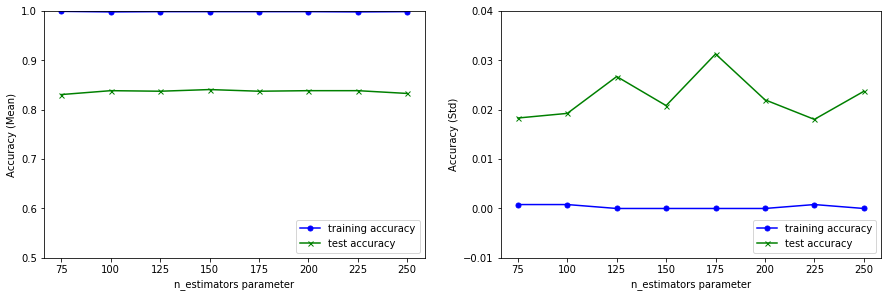

In [20]:
plt.figure(figsize=(15, 10))

model = RandomForestClassifier(n_estimators=150, bootstrap=False, max_features=5, min_samples_split=6)
param_range = range(75, 260, 25)

train_scores, test_scores = validation_curve(estimator=model,
                                             X=X,
                                             y=y,
                                             param_name='n_estimators',
                                             param_range=param_range,
                                            cv = 3)

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.subplot(2,2,1)
plt.plot(param_range,
         train_mean,
         color='blue',
         marker='o',
         markersize=5,
         label='training accuracy')
    
plt.plot(param_range,
         test_mean,
         color='green',
         marker='x',
         markersize=5,
         label='test accuracy') 
    
plt.xlabel('n_estimators parameter')
plt.ylabel('Accuracy (Mean)')
plt.legend(loc='lower right')
_ = plt.ylim([0.5,1])

plt.subplot(2,2,2)
plt.plot(param_range,
         train_std,
         color='blue',
         marker='o',
         markersize=5,
         label='training accuracy')
    
plt.plot(param_range,
         test_std,
         color='green',
         marker='x',
         markersize=5,
         label='test accuracy') 

plt.xlabel('n_estimators parameter')
plt.ylabel('Accuracy (Std)')
_ = plt.legend(loc='lower right')
_ = plt.ylim([-0.01,0.04])

In [21]:
model = RandomForestClassifier(n_estimators=150, bootstrap=False, max_features=5, min_samples_split=6)
create_submition(model, X, y, X_test, test_df.index.values)

Train shape: (891 x 1485)
Test shape: (418 x 1485)


Score: 0.80861, not huge improvement, but some